In [1]:
import numpy as np
from matplotlib import pyplot as plt 
from scipy.stats import multivariate_normal
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch


/Users/lukebailey/opt/miniconda3/envs/misc/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/lukebailey/opt/miniconda3/envs/misc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


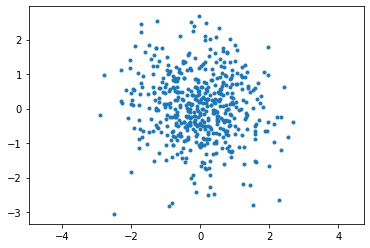

In [2]:
mean = [0, 0]
cov = [[1, 0], [0, 1]]  # diagonal covariance

x, y = np.random.multivariate_normal(mean, cov, 500).T
plt.plot(x, y, '.')
plt.axis('equal')
plt.show()



In [13]:
draws = np.random.multivariate_normal(mean, cov, 10)

var = multivariate_normal(mean=[0,0], cov=[[1,0],[0,1]])
var.pdf(draws)

array([0.10335798, 0.01217306, 0.04213455, 0.03773511, 0.11563955,
       0.10911867, 0.09228165, 0.01553414, 0.03034911, 0.00875666])

# Real Code

In [12]:
# User neural engine
DEVICE = "mps"

class Net(nn.Module):

    def __init__(self, num_classes=2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 20)  
        self.fc2 = nn.Linear(20, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = F.log_softmax(self.fc2(x), dim = 1)
        x = self.fc2(x)
        return x

def test_net(net, dataset):

    criterion = nn.CrossEntropyLoss()
    net.to(DEVICE)
    net.eval()
    total_loss = total_correct = total_examples = 0
    with torch.no_grad():
        for data in dataset:
            
            X,y = data 
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            output = net(X)
            loss = criterion(output, y)
            total_loss += loss.item()
            total_correct += (output.argmax(dim=1) == y).sum().item()
            total_examples += len(y)

    return total_loss, total_correct / total_examples
            

def train_net(epochs, net, trainset, lr=0.001):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr)
    losses = []

    net.train()
    net.to(DEVICE)
    for epoch in range(epochs):
        #if epoch % 10 == 0:
        #    print(f"Epoch {epoch}")
        for data in trainset:
            X, y = data
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            net.zero_grad()
            output = net(X)
            #loss = F.nll_loss(output, y)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

    #plt.plot([i for i in range(len(losses))], losses)
    #plt.title("Training Loss")
    #plt.show()

In [4]:
def get_boundary(prob = 0.01, mean=[0,0], cov=[[1,0], [0,1]]):
    boundary_points = []
    normal_dist = multivariate_normal(mean=mean, cov=cov)

    # Fill boundary points
    while len(boundary_points) < 1000:
        draws = np.random.multivariate_normal(mean, cov, 10)
        draw_dens = normal_dist.pdf(draws)

        for draw, dens in zip(draws, draw_dens):
            if dens <= prob:
                boundary_points.append(draw)

    x = [draw[0] for draw in boundary_points]
    y = [draw[1] for draw in boundary_points]

    plt.plot(x, y, '.')
    plt.axis('equal')

    return boundary_points

def get_boundary_by_prob(prob = 0.01, mean=[0,0], cov=[[1,0], [0,1]], num_clust_points=10000, plot=False):
    boundary_points = []
    all_points = []
    normal_dist = multivariate_normal(mean=mean, cov=cov)

    # Fill boundary points
    draws = np.random.multivariate_normal(mean, cov, num_clust_points)
    draw_dens = normal_dist.pdf(draws)
    for draw, dens in zip(draws, draw_dens):
        all_points.append(draw)
        if dens <= prob:
            boundary_points.append(draw)

    if plot:
        x = [draw[0] for draw in boundary_points]
        y = [draw[1] for draw in boundary_points]

        plt.plot(x, y, '.')
        plt.axis('equal')

    return boundary_points, all_points

def get_dataloader_from_dataset(data, classes, batch_size=4):

    assert(len(data) == len(classes))
    dataset = []

    for boundary, class_ in zip(data, classes):
        for x in boundary:
            dataset.append([x.astype('float32'), class_])

    return DataLoader(dataset, batch_size=batch_size, shuffle=True) 


In [16]:
# Full experiment code

"""
experiment_1 - concerns keep number of points in the dataset the same 
"""
X_1_MEAN = [3,0]
X_1_COV = [[1,0], [0,1]] 
X_2_MEAN = [-3,0]
X_2_COV = [[1,0], [0,1]] 
X_3_MEAN = [0,3]
X_3_COV = [[1,0], [0,1]]

MEANS = [X_1_MEAN, X_2_MEAN, X_3_MEAN]
COVS = [X_1_COV, X_2_COV, X_3_COV]

CLASSES = [0,1]
BATCH_SIZE = 128
EPOCHS = 30

def experiment_1(
    n_vals = list(range(100, 10**3, 100)),
    probs = [0.01, 0.1, 0.2, 0.5, 1],
    clusters = 2,
    plot_dec_boundary = False,
):

    experiment_driver(n_vals, probs, plot_dec_boundary)

def experiment_2(
    n_vals = list(range(100, 10**3, 100)),
    probs = [0.01, 0.1, 0.2, 0.5, 1],
    clusters = 2
):

    experiment_driver_test(n_vals, probs, clusters)

def experiment_driver_test(
    n_vals,
    probs,
    num_clusters,
):

    # Loop through each prob, and each N. For each prob we create a curve
    #   of loss against N
    for prob in probs:
        print(f"P = {prob}")
        loss_vals = []
        acc_vals = []
        for n in n_vals:
            
            # Get data
            bounds_X = []
            fulls_X = []
            classes = list(range(num_clusters))

            for i in range(num_clusters):
                mn = MEANS[i]
                cv = COVS[i]
                bound, full = get_boundary_by_prob(prob=prob, mean=mn, cov=cv, num_clust_points=n)

                assert(len(bound) > 0)

                bounds_X.append(bound)
                fulls_X.append(full)

            # Convert to dataloaders
            boundary_dataloader = get_dataloader_from_dataset(
                bounds_X, 
                classes,
                batch_size=BATCH_SIZE
            )
            full_dataloader = get_dataloader_from_dataset(
                fulls_X, 
                classes,
                batch_size=BATCH_SIZE
            )
            
            # Create and train net
            net = Net(num_classes=3)
            train_net(EPOCHS, net, boundary_dataloader)

            # Test net
            loss, acc= test_net(net, full_dataloader)
            loss_vals.append(loss)
            acc_vals.append(acc)

        plt.plot(n_vals, acc_vals, label=f"p = {prob}") 
    
    plt.title("Accuracy of models across boundary cutoff values")
    plt.legend()
    plt.xlabel("n")
    plt.ylabel("Accuracy")
    plt.show()


def experiment_driver(
    n_vals,
    probs,
    plot_dec_boundary = False,
):

    # Loop through each prob, and each N. For each prob we create a curve
    #   of loss against N
    for prob in probs:
        print(f"P = {prob}")
        loss_vals = []
        acc_vals = []
        for n in n_vals:
            
            # Get data
            bound_X_1, full_X_1 = get_boundary_by_prob(prob=prob, mean=X_1_MEAN, cov=X_1_COV, num_clust_points=n)
            bound_X_2, full_X_2 = get_boundary_by_prob(prob=prob, mean=X_2_MEAN, cov=X_2_COV, num_clust_points=n)

            train_data = []
            for x1, x2 in full_X_1:
                train_data.append([x1,x2, 0])
            for x1, x2 in full_X_2:
                train_data.append([x1,x2, 1])
            train_data = np.array(train_data)
            train_labels = train_data[:,2]


            test_data = []
            for x1, x2 in bound_X_1:
                test_data.append([x1,x2, 0])
            for x1, x2 in bound_X_2:
                test_data.append([x1,x2, 1])
            test_data = np.array(test_data)
            test_labels = test_data[:,2]

            # Convert to dataloaders
            boundary_dataloader = get_dataloader_from_dataset(
                [bound_X_1, bound_X_2], 
                CLASSES,
                batch_size=BATCH_SIZE
            )
            full_dataloader = get_dataloader_from_dataset(
                [full_X_1, full_X_2], 
                CLASSES,
                batch_size=BATCH_SIZE
            )
            
            # Create and train net
            net = Net()
            train_net(EPOCHS, net, boundary_dataloader)

            # Test net
            loss, acc= test_net(net, full_dataloader)
            loss_vals.append(loss)
            acc_vals.append(acc)
            if acc < 0.8 and plot_dec_boundary:
                print(f"Accuracy = {acc}, N = {n}, p = {prob}")
                plot_decision_boundary(
                    train_data, 
                    train_labels, 
                    test_data,
                    test_labels,
                    net
                )

        
        print(f"Accuracy = {acc}, N = {n}, p = {prob}")
        plot_decision_boundary(
            train_data, 
            train_labels, 
            test_data,
            test_labels,
            net
        )

        plt.plot(n_vals, acc_vals, label=f"p = {prob}") 
    
    plt.title("Accuracy of models across boundary cutoff values")
    plt.legend()
    plt.xlabel("n")
    plt.ylabel("Accuracy")
    plt.show()

#def plot_decision_boundary(dataset, labels, model, steps=1000, color_map='Paired'):
def plot_decision_boundary(train_dataset, train_labels, test_dataset, test_labels, model, steps=1000, color_map='Paired'):
    model.to("cpu")
    color_map = plt.get_cmap(color_map)
    # Define region of interest by data limits

    #xmin, xmax = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
    #ymin, ymax = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
    xmin, xmax =  -7, 7 
    ymin, ymax =  -4, 4
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    model.eval()
    labels_predicted = model(Variable(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()))

    labels_predicted = np.argmax(labels_predicted.detach().numpy(), axis=1)
    #print(labels_predicted)
    # Plot decision boundary in region of interest
    labels_predicted = [0 if value <= 0.5 else 1 for value in labels_predicted]
    z = np.array(labels_predicted).reshape(xx.shape)
    
    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=color_map, alpha=0.5)
    # Get predicted labels on training data and plot
    train_labels_predicted = model(torch.tensor(train_dataset[:,:2], dtype=torch.float32))
    ax.scatter(train_dataset[:, 0], train_dataset[:, 1], c=train_labels.reshape(train_labels.shape[0]), cmap=color_map, lw=0, marker='.')
    plt.show()

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=color_map, alpha=0.5)
    # Get predicted labels on training data and plot
    train_labels_predicted = model(torch.tensor(test_dataset[:,:2], dtype=torch.float32))
    ax.scatter(test_dataset[:, 0], test_dataset[:, 1], c=test_labels.reshape(test_labels.shape[0]), cmap=color_map, lw=0, marker='.')
    plt.show()
    return fig, ax

P = 0.01
Accuracy = 0.50475, N = 2000, p = 0.01


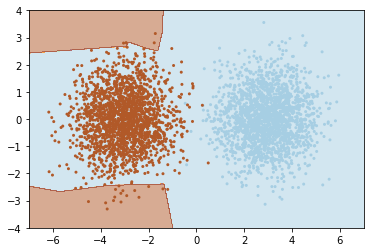

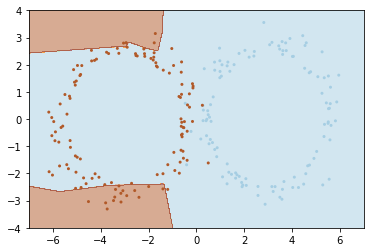

Accuracy = 0.9976262626262626, N = 9900, p = 0.01


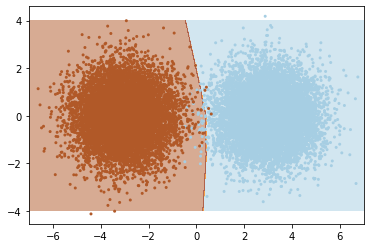

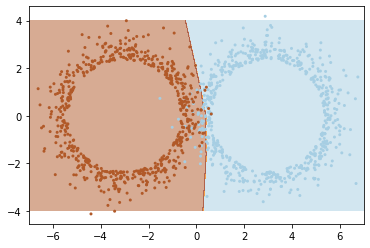

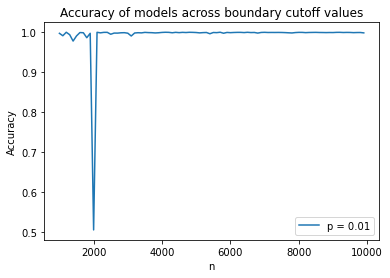

In [17]:
experiment_1(probs = [0.01], n_vals = list(range(10**3, 10**4, 100)), plot_dec_boundary=True)

In [19]:
experiment_1(probs = [0.01,0.1], n_vals = list(range(10**3, 10**4, 100)))

P = 0.01


KeyboardInterrupt: 

P = 0.01
P = 0.1
P = 0.5
P = 1


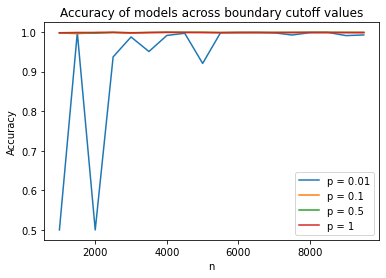

In [13]:
experiment_1(probs = [0.01,0.1, 0.5, 1], n_vals = list(range(10**3, 10**4, 500)))

P = 0.01
P = 0.1
P = 0.5
P = 1


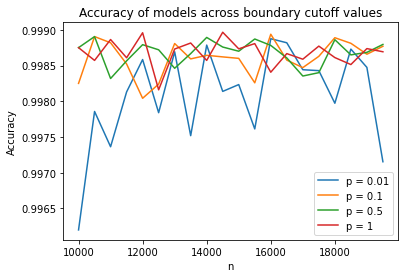

In [41]:
#n = [10**4 + 10**3 * i  for i in range(10)]
n = list(range(10**4, 10**4 * 2, 500))
experiment_1(probs = [0.01,0.1, 0.5, 1], n_vals = n)

P = 0.01
P = 0.1
P = 0.5
P = 1


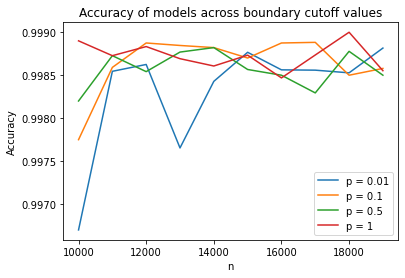

In [14]:
n = [10**4 + 10**3 * i  for i in range(10)]
experiment_1(probs = [0.01,0.1, 0.5, 1], n_vals = n)

P = 0.01
P = 0.1
P = 0.5
P = 1


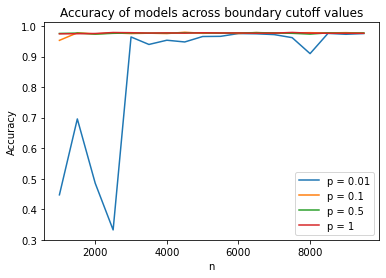

In [24]:
experiment_2(probs = [0.01,0.1, 0.5, 1], n_vals = list(range(10**3, 10**4, 500)), clusters=3)

P = 0.01
P = 0.02
P = 0.05
P = 0.08


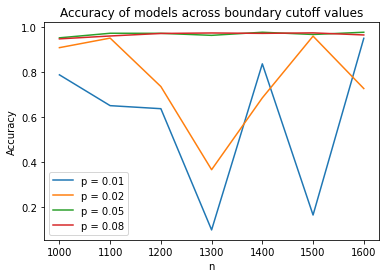

In [26]:
experiment_2(probs = [0.01,0.02, 0.05, 0.08], n_vals = list(range(10**3, 10**3 + 601, 100)), clusters=3)

P = 0.01
P = 0.02
P = 0.05
P = 0.08


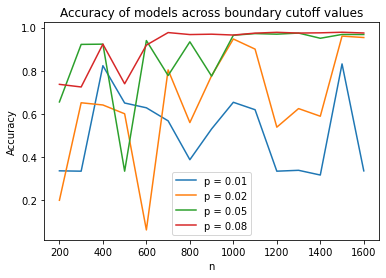

In [30]:
experiment_2(probs = [0.01,0.02, 0.05, 0.08], n_vals = list(range(200, 10**3 + 601, 100)), clusters=3)

P = 0.01
P = 0.02
P = 0.05
P = 0.08


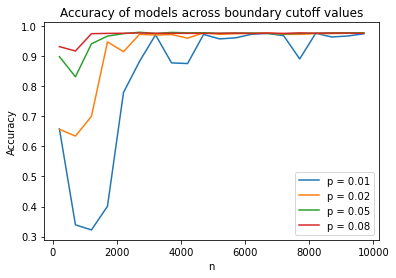

In [32]:
experiment_2(probs = [0.01,0.02, 0.05, 0.08], n_vals = list(range(200, 10**4, 500)), clusters=3)


P = 0.01
P = 0.02
P = 0.05
P = 0.08


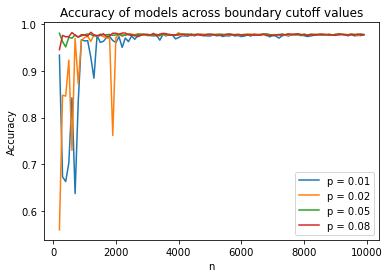

In [20]:
experiment_2(probs = [0.01,0.02, 0.05, 0.08], n_vals = list(range(200, 10**4, 100)), clusters=3)

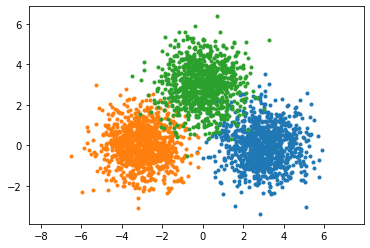

In [46]:
for i in range(3):
    mn = MEANS[i]
    cv = COVS[i]
    bound, full = get_boundary_by_prob(prob=1, mean=mn, cov=cv, num_clust_points=1000, plot=True)

#def get_boundary_by_prob(prob = 0.01, mean=[0,0], cov=[[1,0], [0,1]], num_clust_points=10000, plot=False):
plt.show()

0.06166666666666667
0.057666666666666665


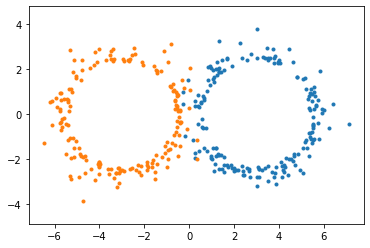

In [51]:
for i in range(2):
    mn = MEANS[i]
    cv = COVS[i]
    bound, full = get_boundary_by_prob(prob=0.01, mean=mn, cov=cv, num_clust_points=3000, plot=True)

    print(len(bound) / len(full))


#def get_boundary_by_prob(prob = 0.01, mean=[0,0], cov=[[1,0], [0,1]], num_clust_points=10000, plot=False):
plt.show()

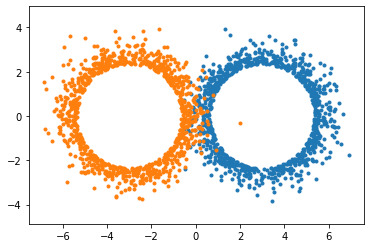

In [94]:
X_1 = get_boundary(prob = 0.01, mean=[3,0], cov=[[1,0], [0,1]])
X_2 = get_boundary(prob = 0.01, mean=[-3,0], cov=[[1,0], [0,1]])
#X_3 = get_boundary(prob = 0.01, mean=[-1,10], cov=[[2,0], [0,2]])
plt.show()


Epoch 0
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90


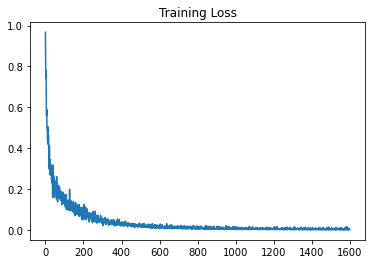

In [85]:
boundary_dataloader = get_dataloader_from_dataset([X_1, X_2], [0,1], batch_size=128)
net = Net()
train_net(100, net, boundary_dataloader)

In [80]:
for X,y in boundary_dataloader:
    with torch.no_grad():
        pred = net(X[:4,:])
        expected = y[:4]
    break


tensor([[ 6.1568, -5.9187],
        [ 6.0728, -6.7014],
        [ 5.9771, -6.8635],
        [ 6.1059, -7.0593]])
tensor([0, 0, 0, 0])
tensor(4)


In [88]:
test_net(net, boundary_dataloader)

(0.06356361205689609, 1.0)